In [ ]:
import pandas as pd 
import numpy as np
import os
import pyprind
import matplotlib.pyplot as plt

# To change date to datetime
from datetime import datetime
import re 

from collections import Counter
import string
import scipy.sparse

# Gensim libraries
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim import matutils

In [ ]:
import pyLDAvis

## Read data and convert the reviews to list

In [ ]:
dataframe = pd.read_csv('clean_reviews.csv')
dataframe.head()

In [ ]:
# Extract lematized words length not less than 2
def minimize_review(text): # text
    rev_text = ([token for token in text.split(' ') if len(token) > 3])
    return rev_text

## Cleaning the data

In [ ]:
clean_reviews = []
for review in dataframe.processed_text:
  clean_reviews.append(minimize_review(review))
len(clean_reviews)

## Topic Modelling using LDA

In [ ]:
%%time
# Create Dictionary
id2word_1 = corpora.Dictionary(clean_reviews)
# Create Corpus: Term Document Frequency
corpus_1 = [id2word_1.doc2bow(review) for review in clean_reviews]
 # Build LDA model
ldamodel = LdaMulticore(corpus= corpus_1, num_topics = 8, id2word=id2word_1,chunksize=2000, passes=10,per_word_topics=True)

In [ ]:
from pprint import pprint
pprint(ldamodel.show_topics(formatted=False))

In [ ]:
# Compute Perplexity
#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', ldamodel.log_perplexity(corpus_1))  

# Compute Coherence Score
# The coherence score is used in assessing the quality of the learned topics, the closer to 1 the better
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_reviews, dictionary=id2word_1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nBasic Ldamodel Coherence Score: ', coherence_lda)

## Choosing the optimal number of topics to optimize coherence

In [ ]:
num_topics = []
coherence = []
model_list = []
for i in range(4,15,2):
    print("Computing for topics = ",i)
    ldamodel = LdaMulticore(corpus= corpus_1, num_topics =i, id2word=id2word_1,chunksize=2000, passes=30,per_word_topics=True)
    model_list.append(ldamodel)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_reviews, dictionary=id2word_1, coherence='c_v')
    num_topics.append(i)
    coherence.append(coherence_model_lda)


In [ ]:
co_values = []
for co_model in coherence:
    co_values.append(co_model.get_coherence())

C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


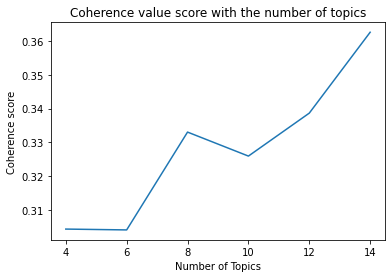

In [39]:
plt.plot(num_topics,co_values)
plt.title("Coherence value score with the number of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

In [ ]:
# printing the best topics
optimal_model = model_list[len(co_values)-1]
model_topics = optimal_model.show_topics(formatted=False)

## Visualizing the topics

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
#Visualize the topic
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(optimal_model, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, 'Lda_viz.html')